In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Exploratory data analysis

We will limit our data to the country **USA**:

In [2]:
def dataframeByRegion(df, region):
    return df[df['region'] == region]

In [3]:
spotify_data = pd.read_csv("../data/spotify_2020+_cleaned.csv")

In [4]:
spotify_data["date"] = pd.to_datetime(spotify_data["date"])

df_united_states = dataframeByRegion(spotify_data, "United States")
#df_united_states.drop(columns=['id'])
df_united_states.dtypes

Unnamed: 0             int64
title                 object
rank                   int64
date          datetime64[ns]
artist                object
url                   object
region                object
chart                 object
trend                 object
dtype: object

first, lets check if a song title is aviable both in **top200** and **viral50** charts:

In [5]:
# returns a list of songs which appear both in top200 and viral50 charts
def get_usable_song_titles(my_data):
    data_by_title = my_data.groupby("title")
    usable_titles = []
    
    for (name,group) in data_by_title.__iter__():
        if ("viral50" in group["chart"].unique() ) and ("top200" in group["chart"].unique()):
            usable_titles.append(name)
            
    usable_titles = pd.Series(usable_titles)
    num_title = len(df_united_states["title"].unique())
    
    print(f" titles which appear in both charts: {usable_titles.count()}\n total number of titles: {num_title}")
    
    return usable_titles

In [6]:
usable_titles = get_usable_song_titles(df_united_states)
usable_title_df = df_united_states[df_united_states["title"].isin(usable_titles)]
usable_title_df["title"].count()

 titles which appear in both charts: 747
 total number of titles: 4887


89136

Next, we create two dataframes for our different charts: **Viral50** and **Top200**

In [7]:
viral_50 = usable_title_df[usable_title_df["chart"] == "viral50"]
viral_50.shape

(17114, 9)

In [8]:
viral_50.head()

,Unnamed: 0,title,rank,date,artist,url,region,chart,trend
10961710,10961710,GOODMORNINGTOKYO!,1,2020-01-01,TOKYO’S REVENGE,https://open.spotify.com/track/0Q2n5yzl2XRqYbV...,United States,viral50,SAME_POSITION
10961712,10961712,"All I Want - From ""High School Musical: The Mu...",2,2020-01-01,Olivia Rodrigo,https://open.spotify.com/track/4Yxc55NX3tAXC2m...,United States,viral50,SAME_POSITION
10961714,10961714,Blueberry Faygo,3,2020-01-01,Mikey.Otx,https://open.spotify.com/track/7oi4xJxGBvqevHz...,United States,viral50,MOVE_UP
10961716,10961716,The Box,4,2020-01-01,Roddy Ricch,https://open.spotify.com/track/0nbXyq5TXYPCO7p...,United States,viral50,MOVE_DOWN
10961720,10961720,No Idea,6,2020-01-01,Don Toliver,https://open.spotify.com/track/3VyjsVV24RmBIbW...,United States,viral50,SAME_POSITION


In [9]:
top_200 = usable_title_df[usable_title_df["chart"] == "top200"]
top_200.shape

(72022, 9)

## APPROACH 1: try viral 50 charts to predict top 200 ranking

In order to plot viral rank vs top 200 rank, we need to create a new dataframe:

In [10]:
# returns a dataframe with mean viral50 rank, mean top 200 rank for song title
def get_rank_title_df(titles, viral_50, top_200):
    viral_ranks = []
    top_200_ranks = []
    titles = titles.tolist()
    for my_title in titles:
        viral_rank = viral_50.loc[viral_50["title"] == my_title, ["rank"]].mean()[0]
        viral_ranks.append(viral_rank)
        top_200_rank = top_200.loc[top_200["title"] == my_title, ["rank"]].mean()[0]
        top_200_ranks.append(top_200_rank)
    df = pd.DataFrame(
        {
            "viral_50_rank_mean" : viral_ranks,
            "top_200_rank_mean" : top_200_ranks,
            "title": titles
        }
    )
    return df

In [11]:
rank_title_df = get_rank_title_df(usable_titles, viral_50 = viral_50, top_200 = top_200)
rank_title_df.sample(10)

,viral_50_rank_mean,top_200_rank_mean,title
533,22.161290,149.250000,Shit
705,35.571429,73.383420,brutal
411,30.666667,146.500000,My Wife & 2 Dogs
40,35.285714,17.416667,All Too Well (10 Minute Version) (Taylor's Ver...
219,21.357143,114.700000,GHOST TOWN
350,38.190476,30.115556,Levitating (feat. DaBaby)
493,39.428571,101.609195,Reminds Me Of You
688,34.428571,66.618357,Yonaguni
295,26.700000,62.000000,I'm Shipping Up To Boston
641,22.210526,63.543027,WITHOUT YOU


### Plotting mean of ranks against each other:
for the entire two years which our spotify data covers

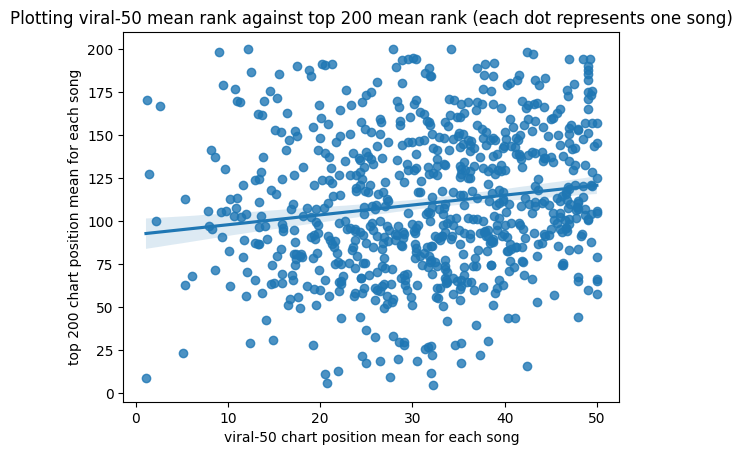

In [12]:
sns.regplot(data=rank_title_df, x = "viral_50_rank_mean", y = "top_200_rank_mean")
plt.title("Plotting viral-50 mean rank against top 200 mean rank (each dot represents one song)")
plt.xlabel("viral-50 chart position mean for each song")
plt.ylabel("top 200 chart position mean for each song")
plt.show()

In [13]:
rank_title_df.corr(method="pearson",numeric_only=True)

,viral_50_rank_mean,top_200_rank_mean
viral_50_rank_mean,1.000000,0.152003
top_200_rank_mean,0.152003,1.000000


As we can see, the viral50 and top 200 ranks are only very weakly correlated. This means that a linear regression model will not suffice to use predict the top200 charts from our viral 50 charts.

## APPROACH 2: try viral 50 charts and trends to predict top 200 ranking

### Plotting ranks against each other for selected weeks within our dataframe: 

In [14]:
# returns a dataframe with mean viral50 rank , mean top 200 rank for song title
def get_rank_title_per_week_df(titles, viral_50, top_200, curr_date = "2020-01-05", delta = 7): 
    date_current = pd.to_datetime(curr_date)
    date_next = date_current + timedelta(days=delta) # date of next week
    
    viral_ranks = []
    top_200_ranks = []
    title_keys = []
    dates_viral = []
    dates_top200 = []
    viral_trends = []
    
    for my_title in titles:
        #print(f"list lengths: viral_ranks length: {len(viral_ranks)}\n top_200 length: {len(top_200_ranks)}\n titles length: {len(titles)}")
        viral_rank = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["rank"]]
        viral_trend = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["trend"]]
        
        if viral_rank.empty:
            #print(f"Error couldnt retrieve viral50 rank for title {my_title}")
            pass
        else:
            viral_ranks.append(viral_rank.iloc[0]["rank"]) # this is a dataframe which should only contain 1 value, we extract it with iloc
            viral_trends.append(viral_trend.iloc[0]["trend"])
            top_200_rank = top_200.loc[(top_200["title"] == my_title) & (top_200["date"] == date_next), ["rank"]]
            if top_200_rank.empty:
                #print(f"Error couldnt retrieve top200 rank for title {my_title}")
                # fix viral data entry so length is the same because there is no top200 rank for this viral rank
                if  len(viral_ranks) > 0:
                    viral_ranks.pop()
                    viral_trends.pop()
            else:
                top_200_ranks.append(top_200_rank.iloc[0]["rank"])# this is a dataframe which should only contain 1 value, we extract it with iloc
                title_keys.append(my_title)
                
    for x in title_keys: # add a start and end date entry to each title found in week timespan, so that the arrays match
        dates_viral.append(date_current) #date of viral 50 rank retrieval
        dates_top200.append(date_next) # date of top 200 rank retrieval
    
    df = pd.DataFrame(
        {
            "title": title_keys,
            "date_viral" : dates_viral,
            "viral_50_rank" : viral_ranks,
            "trend_viral_50" : viral_trends,
            "date_top200" : dates_top200,
            "top_200_rank" : top_200_ranks,
            
        }
    )
    
    return df

In [15]:
# write data to csv for prediction step
weekly_ranks_list = []

dates_to_predict = pd.date_range(start="2020-01-01", end = "2021-12-31", freq = "W")

for tmp_date in dates_to_predict:
        weekly_ranks_list.append(get_rank_title_per_week_df(usable_titles, viral_50 = viral_50, top_200 = top_200, curr_date=tmp_date, delta=7))

In [16]:
df_weekly_ranks = pd.concat(weekly_ranks_list)

# change dtype to integer instead of float
df_weekly_ranks['viral_50_rank'] = df_weekly_ranks['viral_50_rank'].astype('int64')
df_weekly_ranks['top_200_rank'] = df_weekly_ranks['top_200_rank'].astype('int64')

df_weekly_ranks.sample(10)

,title,date_viral,viral_50_rank,trend_viral_50,date_top200,top_200_rank
7,Ignorantes,2020-03-22,48,MOVE_DOWN,2020-03-29,92
2,Breaking Me,2020-05-17,30,MOVE_UP,2020-05-24,200
0,GO (feat. Juice WRLD),2020-07-19,14,SAME_POSITION,2020-07-26,36
15,drivers license,2021-02-21,23,MOVE_UP,2021-02-28,1
9,Whoopty,2020-11-08,9,SAME_POSITION,2020-11-15,43
8,Mood Swings (feat. Lil Tjay),2020-08-09,13,SAME_POSITION,2020-08-16,11
0,Adderall (Corvette Corvette) - Remix,2021-01-17,28,MOVE_DOWN,2021-01-24,145
6,Meet Me At Our Spot,2021-10-31,26,MOVE_DOWN,2021-11-07,15
9,Lil Bit,2021-05-02,49,SAME_POSITION,2021-05-09,146
4,Enchanted,2021-11-14,24,MOVE_UP,2021-11-21,38


In [17]:
df_weekly_ranks.to_csv("../data/weekly_ranks.csv")

just to be sure, lets do the same plot for one **week**: we check the viral50 charts of the current day and see if they correlate with the top200 charts 7 days later:


correlation for week starting at: 2020-01-05T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.349135
top_200_rank        0.349135      1.000000

correlation for week starting at: 2020-01-12T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000     -0.015086
top_200_rank       -0.015086      1.000000

correlation for week starting at: 2020-01-19T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000     -0.021252
top_200_rank       -0.021252      1.000000

correlation for week starting at: 2020-01-26T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000     -0.081978
top_200_rank       -0.081978      1.000000

correlation for week starting at: 2020-02-02T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.151241
top_200_rank        0.151241      1.000000

correlation for week starting

/tmp/ipykernel_29073/4059192620.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


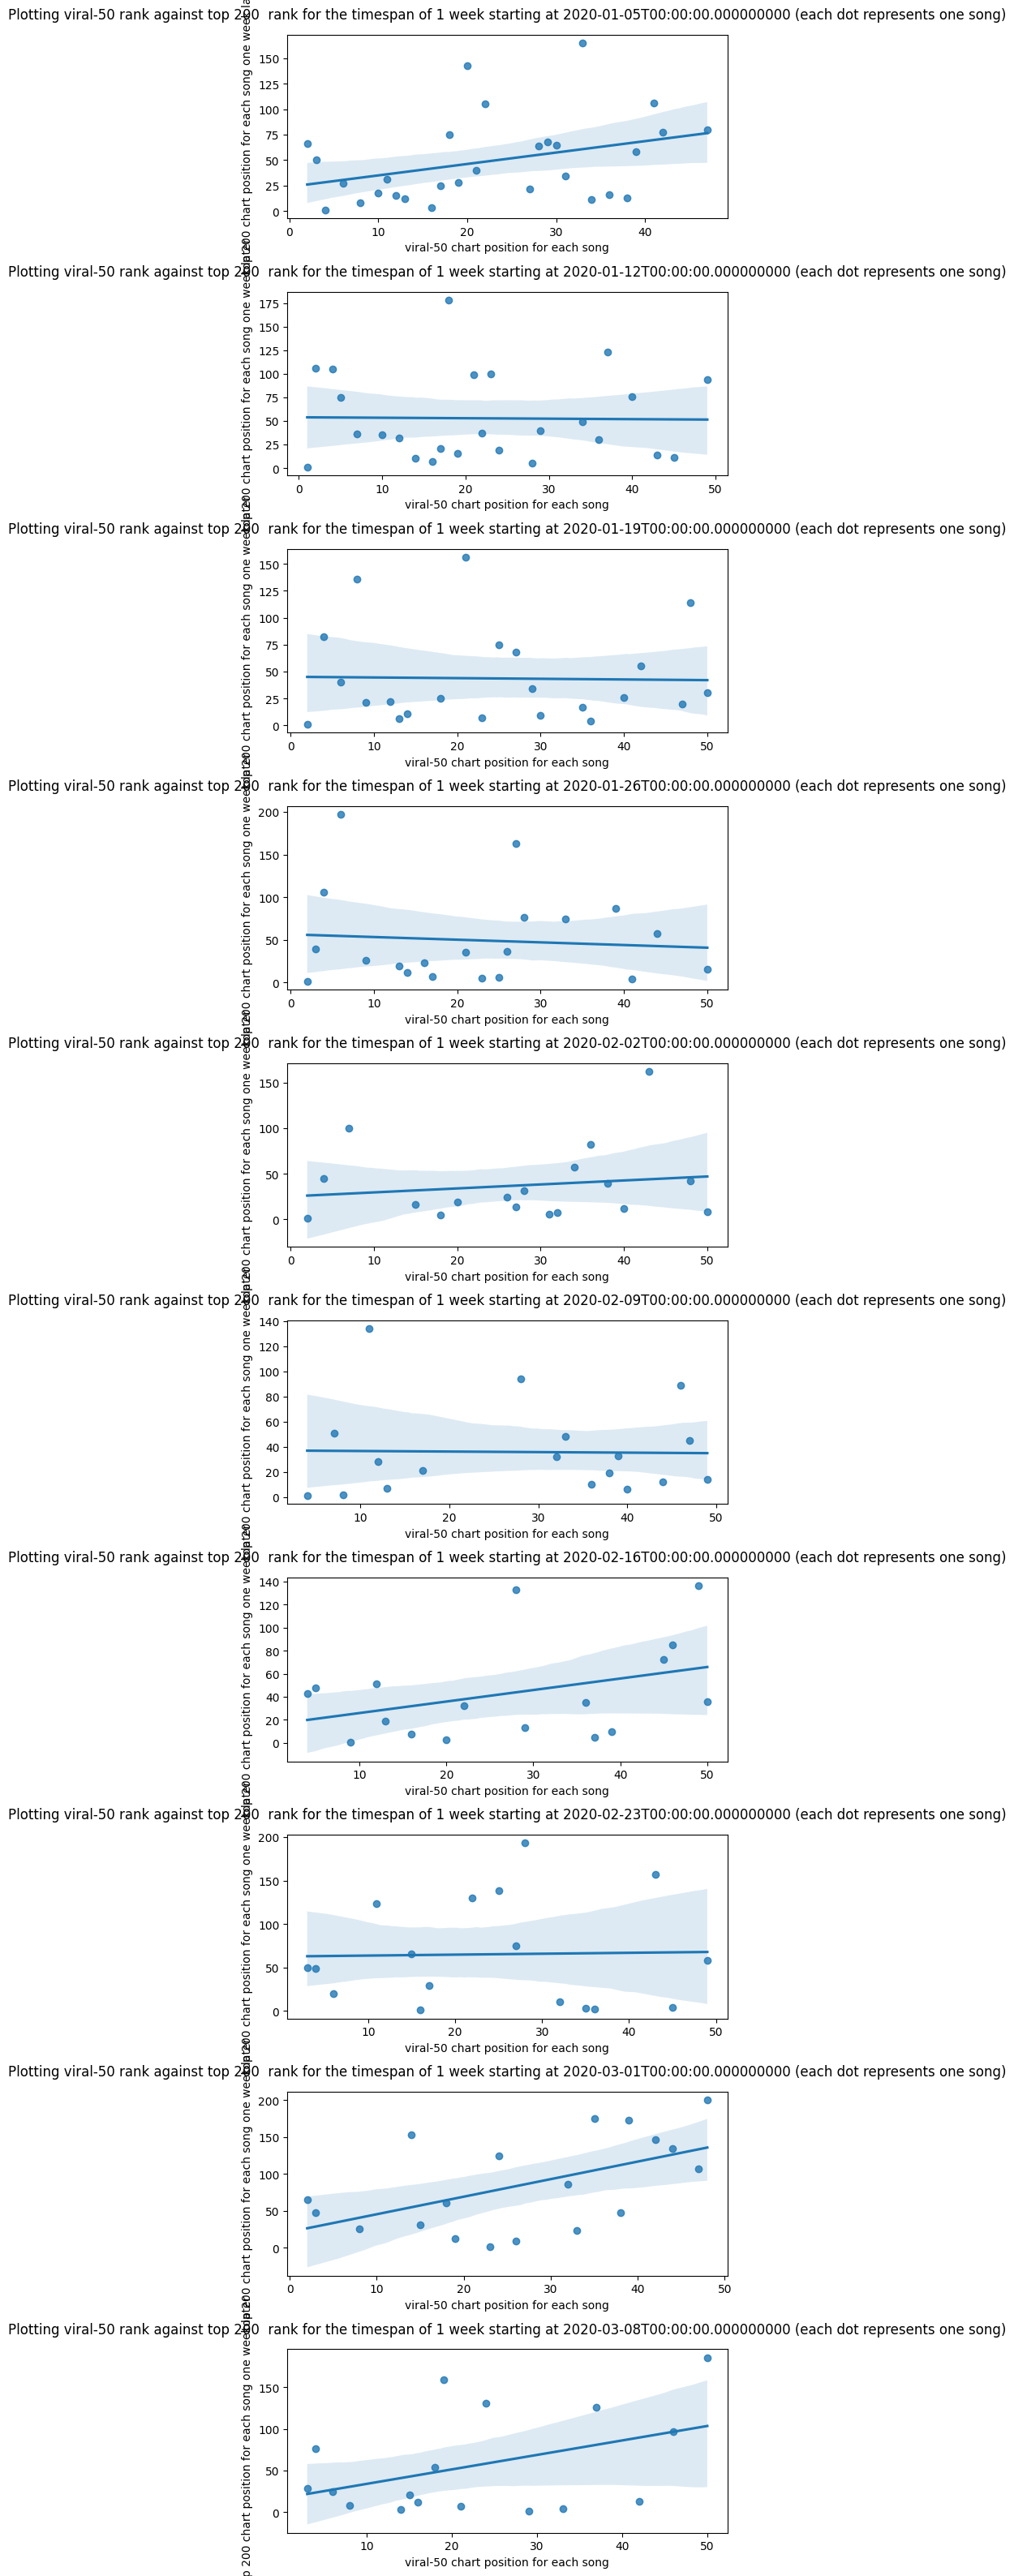

In [18]:
dates = df_weekly_ranks["date_viral"].unique()
i = 0
number_of_plots = 10

fig, ax = plt.subplots(number_of_plots,figsize=(7,40))
plt.subplots_adjust(hspace=0.4)

for date in dates:
    week = df_weekly_ranks[df_weekly_ranks["date_viral"]==date]
    sns.regplot(data=week, x = "viral_50_rank", y = "top_200_rank", ax=ax[i])
    ax[i].set_title(f"Plotting viral-50 rank against top 200  rank for the timespan of 1 week starting at {date} (each dot represents one song)",y=1.05)
    ax[i].set_xlabel("viral-50 chart position for each song")
    ax[i].set_ylabel("top 200 chart position for each song one week later")
    
    print(f"\ncorrelation for week starting at: {date}")
    print(week.corr(method="pearson", numeric_only=True))
    
    i = i+1
    if i >= number_of_plots:
        break
    
fig.show()

We can see that depending on which week we pick, the correlation can be very different. This further supports our discovery from the mean plot.
A possible different approach for our final project could be to look at the **change in rank** instead of the rank itself; if a song moves up in rank over a certain period within the viral50 chart, that could indicate a higher rank in the top 200 chart.

## APPROACH 3: try viral 50 rank to predict top 200 trend

In [19]:
def get_rank_title_per_week_df_for_trends(titles, viral_50, top_200, curr_date = "2020-01-05", delta = 7): # returns a dataframe with mean viral50 rank , mean top 200 rank for song title
    date_current = pd.to_datetime(curr_date)
    date_next = date_current + timedelta(days=delta)
    viral_ranks = []
    top_200_ranks = []
    title_keys = []
    dates_viral = []
    dates_top200 = []
    trends = []
    for my_title in titles:
        viral_rank = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["rank"]]
        if viral_rank.empty:
            pass
        else:
            viral_ranks.append(viral_rank.iloc[0]["rank"]) # this is a dataframe which should only contain 1 value, we extract it with iloc
            top_200_rank = top_200.loc[(top_200["title"] == my_title) & (top_200["date"] == date_next), ["rank"]]
            trend = top_200.loc[(top_200["title"] == my_title) & (top_200["date"] == date_next),["trend"]]
            if top_200_rank.empty:
                # fix viral data entry so length is the same because there is no top200 rank for this viral rank
                if  len(viral_ranks) > 0:
                    viral_ranks.pop()
            else:
                top_200_ranks.append(top_200_rank.iloc[0]["rank"])# this is a dataframe which should only contain 1 value, we extract it with iloc
                trends.append(trend.iloc[0]["trend"])
                title_keys.append(my_title)
    for x in title_keys: # add a  start and end date entry to each title found in week timespan, so that the arrays match
        dates_viral.append(date_current) #date of viral 50 rank retrieval
        dates_top200.append(date_next) # date of top 200 rank retrieval
    df = pd.DataFrame(
        {
            "title": title_keys,
            "date_viral" : dates_viral,
            "viral_50_rank" : viral_ranks,
            "date_top200" : dates_top200,
            "top_200_rank" : top_200_ranks,
            "trend_top_200" : trends
        }
    )
    return df

Start export for predictions.

In [20]:
def export_df_time_window(freq, delta, filename):
    list_trends = []
    dates_to_predict = pd.date_range(start="2020-01-01", end = "2021-12-31", freq = freq)
    for tmp_date in dates_to_predict:
        list_trends.append(get_rank_title_per_week_df_for_trends(usable_titles, viral_50 = viral_50, top_200 = top_200, curr_date=tmp_date, delta=delta))
 
    df_trends = pd.concat(list_trends)

    # change dtype to integer instead of float
    df_trends['viral_50_rank'] = df_trends['viral_50_rank'].astype('int64')
    df_trends['top_200_rank'] = df_trends['top_200_rank'].astype('int64')

    df_trends.to_csv("../data/" + filename)

In [21]:
# write data to csv for prediction step
export_df_time_window("W", 7, "weekly_ranks_top_200.csv")
export_df_time_window("3D", 3, "3_days_ranks_top_200.csv")
export_df_time_window("D", 1, "daily_ranks_top_200.csv")